# Obtain data from netcdf files

In [2]:
import cartopy.crs as ccrs
from cgeniepy.foram import ForamModel as fm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def int_biomass_ts(model_path):
    "integrated foraminifera biomass time series"
    model = fm(model_path)
    time = model.select_var("time").array.values + 0.5
    foram_names = ["bn", "bs", "sn", "ss"]
    data = []

    for iyear in range(len(time)):
        state_foram = 0
        for foram in foram_names:
            state_foram += model.select_foramtype(foram).biomass().isel(time=iyear).sum().magnitude
        data.append(state_foram)
    return time, data

def sst_ts(model_path):
    model = fm(model_path)
    time = model.select_var("time").array
    mean_sst, sd_sst = [],[]
    for iyear in range(len(time)):
        mean_sst.append(model.select_var("ocn_sur_temp").isel(time=iyear).nanmean())
        sd_sst.append(model.select_var("ocn_sur_temp").isel(time=iyear).nansd())
    return mean_sst, sd_sst

def cal_ratio(a1, a2, thershold):
    ratio = np.divide(a1, a2, out=np.zeros_like(a1))
    ratio = (ratio - 1)*100
    ## if any value is smaller than threshold, set the ratio to 0
    ratio[np.where(a2 < thershold)] = 0
    return ratio

def get_assemblage(model_path, year):
    model = fm(model_path)
    return np.array([model.select_foramtype("bn").relative_abundance(threshold=0).take(year, axis=0).array,
                     model.select_foramtype("bs").relative_abundance(threshold=0).take(year, axis=0).array,
                     model.select_foramtype("sn").relative_abundance(threshold=0).take(year, axis=0).array,
                     model.select_foramtype("ss").relative_abundance(threshold=0).take(year, axis=0).array])

from cgeniepy.grid import GENIE_grid_vol
def get_npp(model_path):
    vol = GENIE_grid_vol() * 1E9
    d_to_y = 365
    mmol_to_g = 12 * 1E-3
    g_to_Pg = 1E-15
    model = fm(model_path)
    time = model.select_var("time").array
    data = []
    for iyear in range(len(time)):
        npp_rate = model.select_var("eco2D_Uptake_Fluxes_C").isel(time=iyear).array
        npp_total = np.nansum(npp_rate * vol * d_to_y * mmol_to_g * g_to_Pg)
        data = np.append(data, npp_total)
    return data

from cgeniepy.foram import scd
def dissimilarity(model_path):
    model = fm(model_path)
    time = model.select_var("time").array
    data = []
    for iyear in range(len(time)):
        init_year = get_assemblage("../model/muffin.CBE.worlg4.BASESFeTDTL.historical", 1)
        current_year = get_assemblage(model_path, iyear)
        scd_value = scd(current_year, init_year).nanmean()
        data.append(scd_value)
    return data

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [34]:
## plot pre-industrial age to future
mod_paths = [
    "../model/muffin.CBE.worlg4.BASESFeTDTL.SPIN",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.historical",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.1p5deg",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.2deg",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.3deg",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.4deg",
]

# Store the temporary dataframes in a list
dfs = []

# Iterate over each model path and retrieve the data
for path in mod_paths:
    time_data, biomass_data = int_biomass_ts(path)
    sst_mean, sst_sd = sst_ts(path)
    npp = get_npp(path)
    # Create a temporary dataframe for each model's data
    temp_df = pd.DataFrame({"time": time_data, "biomass": biomass_data,
                           "sst_mean": sst_mean, "sst_sd": sst_sd,
                            "npp": npp})
    temp_df['age'] = path.split(".")[-1]
    temp_df['age'] = temp_df['age'].str.replace("deg", " °C")
    temp_df['age'] = temp_df['age'].str.replace("1p5", "1.5")

    dfs.append(temp_df)

# Concatenate the dataframes from the list
merged_df = pd.concat(dfs, ignore_index=True)

In [35]:
## delete rows with time < 1900
merged_df = merged_df[merged_df['time'] > 1900]

## delete 2000, 5000 which are from the SPINUP
merged_df = merged_df[merged_df['time'] != 2000]
merged_df = merged_df[merged_df['time'] != 5000]
## change the time 10000 to 1765
merged_df['time'] = merged_df['time'].replace(10000, 1765)
merged_df['age'] = merged_df['age'].replace('SPIN', 'pre-industrial')

In [25]:
# develop a function to report foram biomass change
def foram_biomass_change(df, age, time1, time2):
    """
    This function takes in a dataframe and an age (e.g. 1.5 °C) and returns the foram biomass change
    """
    biomass1 = df[df['time'] == time1]['biomass'].iloc[-1]
    biomass2 = df[(df['age'] == age) & (df['time'] == time2)]['biomass'].iloc[-1]
    percent_change = (biomass2 - biomass1) / biomass1 * 100
    return percent_change

foram_biomass_change(merged_df, '1.5 °C', 2022, 2100)

-2.543601711417281

In [36]:
## reference values to compare
ref_biomass = merged_df[merged_df['time'] == 1977]['biomass'].iloc[-1]
ref_sst = merged_df[merged_df['time'] == 1977]['sst_mean'].iloc[-1]
ref_npp = merged_df[merged_df['time'] == 1977]['npp'].iloc[-1]

# Calculate biomass change relative to pre-industrial and convert to percentage
merged_df['biomass'] = (merged_df['biomass'] / ref_biomass) * 100 - 100

# Calculate SST change relative to pre-industrial
merged_df['sst_mean'] = merged_df['sst_mean'] -ref_sst

merged_df['npp'] = (merged_df['npp'] / ref_npp) * 100 - 100

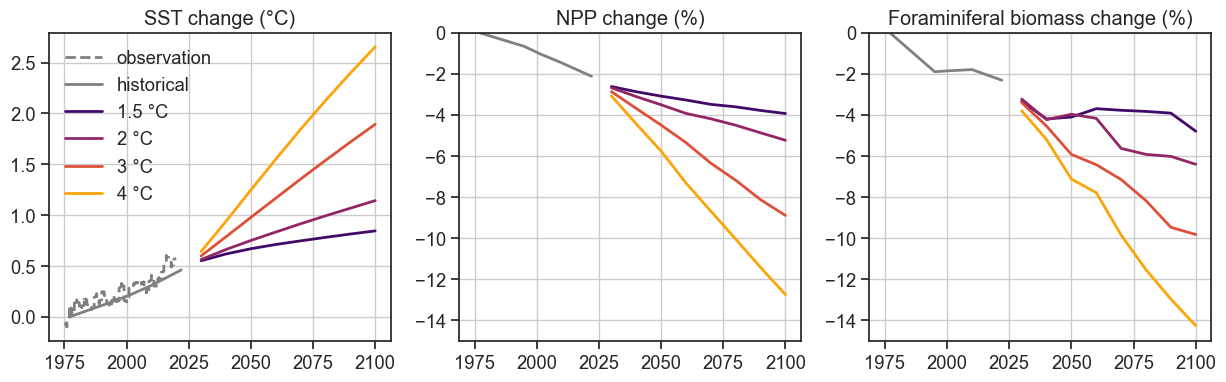

In [68]:
# Plot the data using seaborn
## generate figure
fig, axs = plt.subplots(figsize=(15, 4), nrows=1, ncols=3, sharex=True)

sns.set_style("ticks",{'axes.grid' : True})

sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2})

reds_palette = sns.color_palette("inferno", n_colors=4).as_hex()
# Add grey as the first color in the palette
custom_palette = ["#808080"] + reds_palette

axs[1].set(ylim=(-15, 0))
axs[2].set(ylim=(-15, 0))

import xarray as xr
ersst = xr.open_dataset("../data/modern_env/noaa.ersst.v5.nc").sst
## get global mean
ersst_gm = ersst.mean(dim=["lat", "lon"])
## plot observation in relative change
ersst_gm = ersst_gm - ersst_gm.sel(time=slice("1970-01-01", "1980-01-01")).mean(dim=["time"])
ersst_gm = ersst_gm.sel(time=slice("1975-01-01", "2020-01-01"))
# plot in rolling mean
ersst_gm = ersst_gm.rolling(time=12).mean()
## extract data for plotting
## time in number
ersst_time = ersst_gm.time.values
ersst_time = ersst_time.astype("datetime64[Y]").astype(int) + 1970

## plot in ax[0]
axs[0].plot(ersst_time, ersst_gm, color="#808080", label="observation", linestyle="--")

## remove year < 1975
merged_df = merged_df[merged_df["time"] >= 1975]
sns.lineplot(data=merged_df, x="time", y="sst_mean", hue="age", ax=axs[0], palette=custom_palette)
sns.lineplot(data=merged_df, x="time", y="npp", hue="age", ax=axs[1], legend=False, palette=custom_palette)
sns.lineplot(data=merged_df, x="time", y="biomass", hue="age", ax=axs[2], legend=False, palette=custom_palette)

## 2020-2023 minus 1970-1980 mean
# now = ersst.sst.sel(time=slice("2020-01-01", "2023-01-01")).mean(dim=["lat", "lon", "time"])
# past = ersst.sst.sel(time=slice("1970-01-01", "1980-01-01")).mean(dim=["lat", "lon", "time"])
# print(now.values)
# print(past.values)

for ax in axs:
    ax.set_xlabel("")
    ax.set_ylabel("")

axs[0].legend(title="", frameon=False)
axs[0].set_title("SST change (°C)")
axs[1].set_title("NPP change (%)")
axs[2].set_title("Foraminiferal biomass change (%)")

## export figure
plt.savefig("../output/fig2a.jpg", dpi=300, bbox_inches="tight")
# Show the plot
plt.show()

/var/folders/rq/vks10_qx2l9b08d_pygvwfzh0000gn/T/ipykernel_28763/2213924585.py:32: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(a1, a2, out=np.zeros_like(a1))
/var/folders/rq/vks10_qx2l9b08d_pygvwfzh0000gn/T/ipykernel_28763/2213924585.py:32: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(a1, a2, out=np.zeros_like(a1))


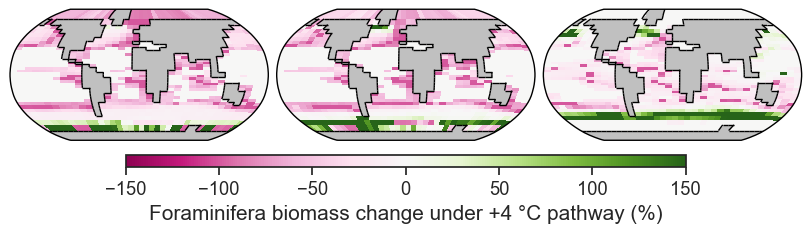

In [72]:
## Create figure and axes
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 2.5),
                        subplot_kw={'projection': ccrs.Robinson()},
                        constrained_layout=True)

modern = fm("../model/muffin.CBE.worlg4.BASESFeTDTL.historical")
future4 = fm("../model/muffin.CBE.worlg4.BASESFeTDTL.2100.4deg")

fnames = ['symbiont-barren non-spinose',
          'symbiont-barren spinose',
          'symbiont-obligate spinose']
from cgeniepy.plot import genie_cmap
cmap = "PiYG"
for i, foramtype in enumerate(["bn", "bs", "ss"]):
    #axs[i].set_title(fnames[i], fontsize=13, fontweight="bold")
    modern_biomass = modern.select_foramtype([foramtype]).biomass(combine_vars=True).take(-1, axis=0)
    future_biomass = future4.select_foramtype([foramtype]).biomass(combine_vars=True).take(-1, axis=0)
    diff = future_biomass - modern_biomass ## a fake diff, will change the value using cal_ratio
    diff.array = cal_ratio(future_biomass.array, modern_biomass.array, 1e-10)
    p = diff.plot_map(ax=axs[i], cmap=cmap, vmin=-150, vmax=150, colorbar=False)

# Add color bar on the bottom side of the figure
cax = fig.add_axes([0.15, 0.13, 0.7, 0.05])
cbar = fig.colorbar(p, cax=cax, orientation='horizontal', fraction=0.05)
cbar.set_label(r"Foraminifera biomass change under +4 °C pathway (%)", fontsize=15)

# Save the figure
fig.savefig("../output/fig2c.jpg", dpi=300, bbox_inches="tight")

## Integrated Biomass change

In [2]:
def group_biomass_ts(model_path):
    "foraminifera ecogroup biomass time series"
    model = fm(model_path)
    time = model.select_var("time").array.values + 0.5
    foram_names = ["bn", "bs", "ss"]

    ## initialize data_all
    data_all = np.zeros((len(time), len(foram_names)))
    for foram in foram_names:
        data = []
        for iyear in range(len(time)):
            foram_biomass = model.select_foramtype(foram).biomass().isel(time=iyear).sum().magnitude
            data.append(foram_biomass)
        data = np.array(data)
        data_all[:, foram_names.index(foram)] = data
    ## add time
    data_all = np.hstack((time.reshape(-1, 1), data_all))
    ## convert to dataframe
    data_all = pd.DataFrame(data_all, columns=["time", "symbiont-barren non-spinose", "symbiont-barren spinose", "symbiont-obligate spinose"])
    return data_all

## plot pre-industrial age to future
mod_paths = [
    "../model/muffin.CBE.GIteiiva.BASESFeTDTL_rb.SPIN",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.SPIN",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.historical",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.1p5deg",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.2deg",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.3deg",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.4deg",
]

## init a list to store data
biomass_data = []
for path in mod_paths:
    mod_group_biomass = group_biomass_ts(path)
    ## add group column based on model path
    if "GIteiiva" in path:
        mod_group_biomass["age"] = "LGM"
    elif "BASESFeTDTL.SPIN" in path:
        mod_group_biomass["age"] = "PI"
    elif "historical" in path:
        mod_group_biomass["age"] = "historical"
    elif "2100" in path:
        mod_group_biomass["age"] = "+"+path.split(".")[-1]
    biomass_data.append(mod_group_biomass)

## concat data
biomass_data = pd.concat(biomass_data)

## longer data format
biomass_data = pd.melt(biomass_data, id_vars=["time", "age"], var_name="foramtype", value_name="biomass")

In [8]:
biomass_future = biomass_data.loc[(biomass_data['age'] != "PI") & (biomass_data['age'] != "LGM")]
biomass_future = biomass_future[biomass_future['time'] > 1900]
biomass_future

,time,age,foramtype,biomass
27,1977.0,historical,symbiont-barren non-spinose,0.013415
28,1995.0,historical,symbiont-barren non-spinose,0.012851
29,2001.0,historical,symbiont-barren non-spinose,0.012926
30,2010.0,historical,symbiont-barren non-spinose,0.013032
31,2022.0,historical,symbiont-barren non-spinose,0.012970
...,...,...,...,...
187,2060.0,+4deg,symbiont-obligate spinose,0.008078
188,2070.0,+4deg,symbiont-obligate spinose,0.007997
189,2080.0,+4deg,symbiont-obligate spinose,0.007900
190,2090.0,+4deg,symbiont-obligate spinose,0.007809


In [27]:
## get total biomass in 1977
total_historical = biomass_future[biomass_future['time']==1977]
total_future = biomass_future[(biomass_future['time']==2100) & (biomass_future['age']=='+3deg')]

## proportion of non-symbiont group
total_change = total_future.biomass.sum() - total_historical.biomass.sum()
symbiont_foram_part =  total_future.biomass.iloc[2] - total_historical.biomass.iloc[2]
symbiont_foram_part/total_change

0.14819490805837876

In [75]:
## plot time series of future run
biomass_future = biomass_data.loc[(biomass_data['age'] != "PI") & (biomass_data['age'] != "LGM")]
biomass_future = biomass_future[biomass_future['time'] > 1900]

## calculate relative biomass change
biomass_future = biomass_future.groupby("foramtype").apply(lambda g: g.assign(relative_change=g['biomass'] / g['biomass'].iloc[0] - 1))

biomass_future['relative_change'] = biomass_future['relative_change'] * 100
sns.set_theme(style="ticks")
sns.set_palette("colorblind")  # Use a colorblind-friendly palette
sns.lineplot(data=biomass_future, x="time", y="relative_change", hue="foramtype", style="age", errorbar=None, legend="brief")

## put legend outside
plt.legend(bbox_to_anchor=(0.05, 0.65), loc=2, borderaxespad=0., frameon=False)
sns.despine()  # Remove the top and right spines
plt.xlabel("Time")
plt.ylabel("Relative Biomass Change (%)")
# plt.title("Foraminiferal Biomass Change of Each Ecogroup")
plt.savefig("../output/figs8.jpg", dpi=300, bbox_inches="tight")

AttributeError: 'list' object has no attribute 'loc'

In [ ]:
biomass_data_future['foramtype'].unique()